# Rice Disease Detection 5-Types

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Path to your dataset directory
train_dir = '/kaggle/input/rice-leafs-disease-dataset/RiceLeafsDisease/train'
bacterial_leaf_blight_dir = os.path.join(train_dir, 'bacterial_leaf_blight')
brown_spot_dir = os.path.join(train_dir, 'brown_spot')
healthy_dir = os.path.join(train_dir, 'healthy')
leaf_blast_dir = os.path.join(train_dir, 'leaf_blast')
leaf_scald_dir = os.path.join(train_dir, 'leaf_scald')
narrow_brown_spot_dir = os.path.join(train_dir, 'narrow_brown_spot')

In [5]:
# Function to read images from a directory
def read_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
def resize_images(images, target_size=(299, 299)):
    resized_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)


In [7]:
# Function to normalize images
def normalize_images(images):
    return images.astype('float32') / 255.0

In [8]:
# Function to create and compile model
def create_and_compile_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(6, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
# Function to clear TensorFlow session
def clear_tensorflow_session():
    import tensorflow as tf
    tf.keras.backend.clear_session()

In [10]:
# Read images from each class directory
bacterial_leaf_blight_images = read_images_from_dir(bacterial_leaf_blight_dir)
brown_spot_images = read_images_from_dir(brown_spot_dir)
healthy_images = read_images_from_dir(healthy_dir)
leaf_blast_images = read_images_from_dir(leaf_blast_dir)
leaf_scald_images = read_images_from_dir(leaf_scald_dir)
narrow_brown_spot_images = read_images_from_dir(narrow_brown_spot_dir)

In [11]:
# Print the number of images in each class
print("Number of Bacterial Leaf Blight images:", len(bacterial_leaf_blight_images))
print("Number of Brown Spot images:", len(brown_spot_images))
print("Number of Healthy images:", len(healthy_images))
print("Number of Leaf Blast images:", len(leaf_blast_images))
print("Number of Leaf Scald images:", len(leaf_scald_images))
print("Number of Narrow Brown Spot images:", len(narrow_brown_spot_images))

Number of Bacterial Leaf Blight images: 350
Number of Brown Spot images: 350
Number of Healthy images: 350
Number of Leaf Blast images: 350
Number of Leaf Scald images: 350
Number of Narrow Brown Spot images: 350


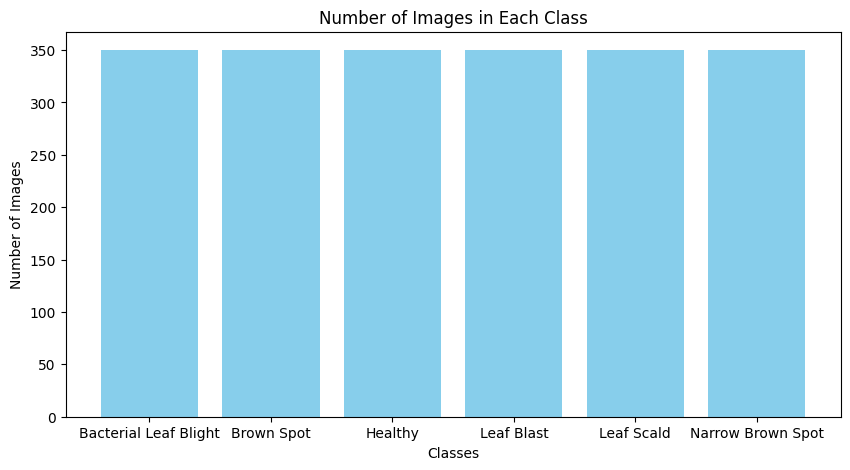

In [12]:
# Create bar graph
classes = ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy', 'Leaf Blast', 'Leaf Scald', 'Narrow Brown Spot']
counts = [
    len(bacterial_leaf_blight_images),
    len(brown_spot_images),
    len(healthy_images),
    len(leaf_blast_images),
    len(leaf_scald_images),
    len(narrow_brown_spot_images)
]

plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [13]:
# Normalize images
normalized_bacterial_leaf_blight = normalize_images(resize_images(bacterial_leaf_blight_images))
normalized_brown_spot = normalize_images(resize_images(brown_spot_images))
normalized_healthy = normalize_images(resize_images(healthy_images))
normalized_leaf_blast = normalize_images(resize_images(leaf_blast_images))
normalized_leaf_scald = normalize_images(resize_images(leaf_scald_images))
normalized_narrow_brown_spot = normalize_images(resize_images(narrow_brown_spot_images))

In [14]:
# Delete unnecessary variables to free up memory
del bacterial_leaf_blight_images, brown_spot_images, healthy_images, leaf_blast_images, leaf_scald_images, narrow_brown_spot_images


In [15]:
# Concatenate images and labels
X = np.concatenate((normalized_bacterial_leaf_blight, normalized_brown_spot, normalized_healthy,
                    normalized_leaf_blast, normalized_leaf_scald, normalized_narrow_brown_spot), axis=0)
y = np.array([0]*len(normalized_bacterial_leaf_blight) + [1]*len(normalized_brown_spot) + 
             [2]*len(normalized_healthy) + [3]*len(normalized_leaf_blast) + 
             [4]*len(normalized_leaf_scald) + [5]*len(normalized_narrow_brown_spot))

In [16]:
# Shuffle X and y in unison
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [18]:
# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_test, y_test, batch_size=32)

In [20]:
# Create and compile the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [21]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Train the model
history = model.fit(train_generator, epochs=20, steps_per_epoch=len(X_train) // 32,
                    validation_data=val_generator, validation_steps=len(X_test) // 32, verbose=1)


Epoch 1/20
 1/52 ━━━━━━━━━━━━━━━━━━━━ 28:54 34s/step - accuracy: 0.1562 - loss: 2.2638

I0000 00:00:1709495550.200856     307 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709495550.248271     307 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/52 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.2017 - loss: 2.0088 

W0000 00:00:1709495571.764569     308 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.2994 - loss: 1.7406

W0000 00:00:1709495594.998104     305 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 902ms/step - accuracy: 0.3011 - loss: 1.7363 - val_accuracy: 0.6755 - val_loss: 1.1178
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.5938 - loss: 1.1650 - val_accuracy: 1.0000 - val_loss: 0.8452
Epoch 3/20


W0000 00:00:1709495605.987854     306 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 506ms/step - accuracy: 0.6160 - loss: 1.0697 - val_accuracy: 0.7692 - val_loss: 0.8029
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.6250 - loss: 0.9975 - val_accuracy: 1.0000 - val_loss: 0.6685
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 502ms/step - accuracy: 0.6998 - loss: 0.8586 - val_accuracy: 0.8125 - val_loss: 0.6782
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.6875 - loss: 0.8020 - val_accuracy: 1.0000 - val_loss: 0.4572
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 508ms/step - accuracy: 0.7398 - loss: 0.7126 - val_accuracy: 0.8341 - val_loss: 0.5599
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.7188 - loss: 0.7498 - val_accuracy: 1.0000 - val_loss: 0.3288
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 502ms/step - accuracy: 0.7914 - loss: 0.6370 - val_accuracy: 0.8678 - val_loss: 0.5004
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7188 - loss: 0.5601 - val_accuracy: 0.7500 -

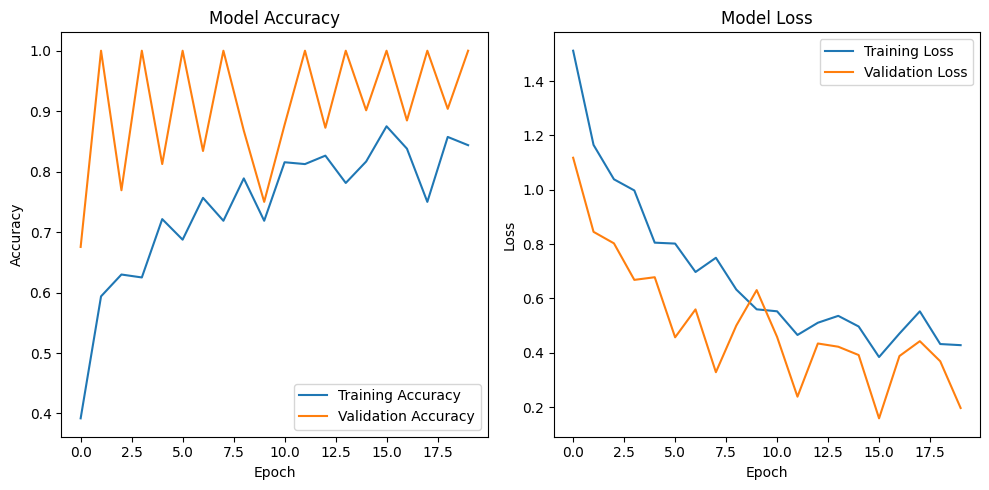

In [24]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate the model on test data
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy:", accuracy)

W0000 00:00:1709495885.225918     308 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy: 0.9095237851142883


W0000 00:00:1709495890.042172     305 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
# Predict labels
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step

W0000 00:00:1709495896.216878     305 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step
Precision: 0.9171995721115742
Recall: 0.9095238095238095
F1-score: 0.9079527544379252


W0000 00:00:1709495903.121101     305 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[81  0  0  1  3  2]
 [ 1 68  0  0  0  2]
 [ 0  1 66  2  0  0]
 [ 3 16  0 41  1  1]
 [ 0  1  0  0 58  0]
 [ 1  3  0  0  0 68]]


In [33]:
# Define a function to predict the label of an uploaded image
def predict_uploaded_image(model, image_file):
    # Load and preprocess the image
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (299, 299))  # Resize to match model's expected sizing
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img)
    
    # Get the predicted class
    class_idx = np.argmax(predictions)
    
    # Define the class labels
    class_names = {
        0: 'Bacterial Leaf Blight',
        1: 'Brown Spot',
        2: 'Healthy',
        3: 'Leaf Blast',
        4: 'Leaf Scald',
        5: 'Narrow Brown Spot'
    }
    
    # Get the predicted class label
    predicted_class = class_names[class_idx]
    
    # Get the confidence score
    confidence = predictions[0][class_idx]

    return predicted_class, confidence

# Load the saved model
#model = load_model('Rice-Model.h5')  # Load your trained model here

# Path to the image you want to predict
image_path = '/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images/Brownspot/BROWNSPOT1_011.jpg'  # Provide the path to your rice image

# Predict the image
predicted_class, confidence = predict_uploaded_image(model, image_path)

# Print the result
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: Brown Spot
Confidence: 0.74527353
